# EMD comparisons for SIGNAL-seq ADT and CyTOF data

In [1]:
# Load packages
import anndata as ad
import scanpy as sc
import muon as mu
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys, os, argparse

# Import utils
# Get the current working directory
current_dir = os.getcwd()
utils_path = os.path.join(current_dir, '../../', 'utils')
sys.path.append(utils_path)


# Import adt utils functions
from adt_utils import calculate_emd

In [2]:
# Setup the global plotting parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = 'viridis', frameon=True, transparent=True,
                    dpi_save=800, facecolor='None', format='pdf', figsize=[5,5])

# Figure output directory
sc.settings.figdir = 'emd_figures'

# Colour map
# Fill in the clusters that belong to each cell type based on each marker in the plot above
colour_dict = {'Control': 'tab:blue', 
               'EGF IGF1': 'tab:green', 
               'GFs MEKi PI3Ki': 'tab:red'}

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


## Import data objects

In [3]:
# File path - Also load Muon object
fp_mdata = '../02_preprocessing_multimodal/2023_03_30_mdata_01.h5mu'

# Load the Muon SIGNAL-seq object
mdata = mu.read(fp_mdata)

mdata

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 1143 × 29260
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	1143 x 29237
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'S_score', 'G2M_score', 'phase', 'Amit_Nat_Gen_2007'
      var:	'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'X_name', 'library_info', 'library_stats', 'log1p', 'seq_run_info'
      layers:	'counts', 'reads'
    protein:	1143 x 23
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
      var:	'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      layers:	'counts'

In [4]:
# Load the CyTOF data
cytof_fp = "data/cytof_data/ex0003_asinh_casp_status.csv"
cytof_df = pd.read_csv(cytof_fp)

cytof_df

,pHistone_H3_S28,Vimetin,EpCAM CD326_v4,CK18,Pan-CK _v8,GFP_v3,pPDK1_S241_v7,cCaspase 3_D175_v4,pMKK4_SEK1_S257_v6,pBTK1_Y551_v8,...,pP38MAPK_T180_Y182_v5,pHistone_H2AX_S139_v5,p90RSK_T359_v7,p120_catenin_T310_v3,pS6_S240_S244_v2,CD44_v3,Cyclin_B1_v6,209Bi_me2_Histone_H3_K4_(Bi209Di),condition,casp3_status
0,0.000000,1.472606,0.605936,0.683973,2.295551,0.347098,0.848352,3.305875,0.000000,2.069379,...,0.265449,3.607962,0.120572,4.210182,2.541614,3.847914,0.000000,6.038158,Control,cCasp3 low
1,1.111344,4.087337,2.081407,4.887064,1.452100,0.542329,3.639001,2.548589,2.932133,2.716827,...,4.073902,2.630386,3.434234,7.537145,4.927570,5.868002,1.456444,6.924871,Control,cCasp3 low
2,0.045117,3.776552,1.717895,3.954299,1.715066,0.055846,3.307163,2.550353,2.620795,2.379874,...,3.805543,2.312755,3.611810,7.775783,5.027503,5.716199,1.800443,6.376853,Control,cCasp3 low
3,0.882807,4.644352,1.288296,3.803409,1.119182,0.861757,3.531538,2.886353,1.956604,2.522027,...,4.509470,2.930757,2.605197,7.851448,4.729678,5.954482,2.182581,6.808498,Control,cCasp3 low
4,1.137455,3.825816,1.893742,2.416011,1.384218,0.570799,4.108008,3.019432,3.643629,2.483018,...,3.778976,4.247198,3.168629,7.926657,5.383174,6.367021,3.821730,6.368905,Control,cCasp3 low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38319,0.244635,0.295781,1.401292,0.000000,1.017633,0.000000,0.745596,4.744218,1.193201,1.394899,...,1.278596,5.072744,2.050453,3.522983,3.854718,4.093540,1.294885,6.579498,Inhibitors,cCasp3 high
38320,0.505549,5.825333,1.835989,1.581100,1.786307,0.091972,3.143127,5.236637,2.269990,1.249846,...,3.235283,4.796371,1.676796,5.406665,4.686339,5.114669,4.199603,4.679960,Inhibitors,cCasp3 high
38321,0.104296,2.016163,0.285041,1.475214,3.521449,0.521845,2.122703,4.799139,1.494931,2.515340,...,0.969273,4.060713,1.851789,3.919934,3.366106,5.148964,0.728260,6.282317,Inhibitors,cCasp3 high
38322,0.000000,3.486314,0.508506,0.655898,0.940215,0.000000,1.842194,4.161755,0.577505,1.572815,...,2.658555,5.338397,1.810459,4.532403,3.637015,5.305716,0.745271,5.542267,Inhibitors,cCasp3 high


In [5]:
# Isolate the PTM functional markers
cytof_ptm_markers = ['condition', 'p120_catenin_T310_v3',
 'pRB_S807_811_v7', 'cCaspase 3_D175_v4', 'pPDK1_S241_v7',
 'pMKK4_SEK1_S257_v6', 'pBTK1_Y551_v8', 'p4E_BP1_T37_46_v5',
 'pAKT_T308_v11', 'pNF_KB_p65_S529_v6', 'pP38MAPK_T180_Y182_v5',
 'pS6_S240_S244_v2', 'CK18', 'Cyclin_B1_v6', 'pNDRG1_T346_v2', '209Bi_me2_Histone_H3_K4_(Bi209Di)'
 ]

cytof_df_filter = cytof_df[cytof_ptm_markers]

# renaming the condition column
cytof_df_filter.rename(columns = {"condition": "sample_id"}, 
          inplace = True)

cytof_df_filter.rename(columns = {"209Bi_me2_Histone_H3_K4_(Bi209Di)": "me2_Histone_H3_[K4]"}, 
          inplace = True)

cytof_df_filter['sample_id'] = cytof_df_filter['sample_id'].replace(['Control', 'Inhibitors', 'GF_stim'], 
                                ['Control', 'GFs MEKi PI3Ki', 'EGF IGF1'])

cytof_df_filter

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/1224783076.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof_df_filter.rename(columns = {"condition": "sample_id"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/1224783076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof_df_filter.rename(columns = {"209Bi_me2_Histone_H3_K4_(Bi209Di)": "me2_Histone_H3_[K4]"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/1224783076.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,sample_id,p120_catenin_T310_v3,pRB_S807_811_v7,cCaspase 3_D175_v4,pPDK1_S241_v7,pMKK4_SEK1_S257_v6,pBTK1_Y551_v8,p4E_BP1_T37_46_v5,pAKT_T308_v11,pNF_KB_p65_S529_v6,pP38MAPK_T180_Y182_v5,pS6_S240_S244_v2,CK18,Cyclin_B1_v6,pNDRG1_T346_v2,me2_Histone_H3_[K4]
0,Control,4.210182,2.055959,3.305875,0.848352,0.000000,2.069379,0.307548,0.855389,0.495979,0.265449,2.541614,0.683973,0.000000,0.102038,6.038158
1,Control,7.537145,6.252096,2.548589,3.639001,2.932133,2.716827,3.482879,4.184201,3.642103,4.073902,4.927570,4.887064,1.456444,6.378743,6.924871
2,Control,7.775783,6.297030,2.550353,3.307163,2.620795,2.379874,3.486443,4.399848,3.419234,3.805543,5.027503,3.954299,1.800443,5.783391,6.376853
3,Control,7.851448,6.344481,2.886353,3.531538,1.956604,2.522027,3.274157,3.945218,3.456268,4.509470,4.729678,3.803409,2.182581,4.778783,6.808498
4,Control,7.926657,7.119292,3.019432,4.108008,3.643629,2.483018,4.149670,4.855598,4.266564,3.778976,5.383174,2.416011,3.821730,5.371620,6.368905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38319,GFs MEKi PI3Ki,3.522983,2.926631,4.744218,0.745596,1.193201,1.394899,0.483434,0.941395,3.117756,1.278596,3.854718,0.000000,1.294885,0.682578,6.579498
38320,GFs MEKi PI3Ki,5.406665,4.119306,5.236637,3.143127,2.269990,1.249846,1.224918,3.341082,3.040008,3.235283,4.686339,1.581100,4.199603,1.653228,4.679960
38321,GFs MEKi PI3Ki,3.919934,1.195866,4.799139,2.122703,1.494931,2.515340,0.723778,0.573937,2.176864,0.969273,3.366106,1.475214,0.728260,3.349176,6.282317
38322,GFs MEKi PI3Ki,4.532403,3.375179,4.161755,1.842194,0.577505,1.572815,0.000000,2.323224,1.428471,2.658555,3.637015,0.655898,0.745271,0.710666,5.542267


In [6]:
# Extract and subset the SIGNAL-seq ADT data
protein_mudata = mdata["protein"]

# Export the protein data as df
marker_genes = protein_mudata.var_names

protein_data_clr_df = sc.get.obs_df(
    protein_mudata,
    keys=['sample_id', *marker_genes]
)

protein_data_clr_df 

,sample_id,Rat_IgG_Control,CD44_v4,pP120-Catenin_[T310],pRB_[S807/811]_v1,me2_Histone_H3_[K4],cCaspase_3_[D175]_v2,Mouse_IgG_Control,pPDPK1_[S241],pMKK4/SEK1_[S257],...,pP38_MAPK_[T180/Y182]_v2,pHistone_H2A.X_[S139]_3,pS6_[S240/S244]_2,Pan-CK,CK18,Vimentin,Cyclin_B1_2,pNDRG1_[T346],pHistone_H3_[Ser28]_v3,Rabbit_IgG_Control
barcode,,,,,,,,,,,,,,,,,,,,,
AAACATCGACATTGGCCGTCTAGG,GFs MEKi PI3Ki,0.575127,0.873346,1.761587,1.205852,0.000000,0.085918,0.000000,0.702468,0.492094,...,0.483965,0.448214,0.316901,0.596661,0.863648,0.595571,0.383284,1.361001,0.0,1.078848
AAACATCGACCTCCAATTGTCTTA,EGF IGF1,0.575127,1.240929,1.149642,1.238668,0.000000,0.085918,0.580964,0.886334,0.492094,...,0.000000,0.448214,4.653180,0.240602,1.538613,0.240084,0.876004,2.344237,0.0,0.772315
AAACATCGAGCAGGAAAGGCGGCA,EGF IGF1,0.575127,0.212225,0.410482,0.511900,1.046017,0.773028,0.000000,0.185438,0.669677,...,0.270979,0.991970,1.458586,0.240602,1.189771,0.857295,1.053747,0.135409,0.0,0.772315
AAACATCGATGCCTAAACTCGTAA,Control,0.575127,0.303534,0.367487,0.442792,0.143111,0.085918,0.000000,0.341809,0.276016,...,0.483965,0.000000,0.071924,0.240602,0.000000,0.000000,0.000000,0.254650,0.0,0.177417
AAACATCGCAGCGTTATTGTCTTA,EGF IGF1,0.000000,0.701428,0.491294,0.288354,0.379513,0.430678,0.000000,0.341809,0.276016,...,1.156483,0.000000,0.122663,0.434396,0.000000,0.000000,0.383284,0.135409,0.0,1.010567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACCGAAGTACGTTCGAG,Control,0.575127,0.769406,0.731662,0.939904,1.545984,1.718390,0.580964,0.341809,0.669677,...,0.270979,0.756605,0.170952,0.736236,0.376562,0.734971,0.383284,0.254650,0.0,0.772315
TTCACGCACTCAATGACGCCCGGA,EGF IGF1,0.000000,1.170126,0.491294,0.442792,1.196303,1.089829,0.000000,0.596076,0.492094,...,1.335325,0.000000,0.395231,0.000000,0.000000,0.595571,0.000000,0.135409,0.0,0.678360
TTCACGCAGCCAAGACAAACGATA,Control,0.000000,0.249755,0.275520,0.105629,0.479602,0.430678,0.000000,0.185438,0.000000,...,0.270979,0.448214,0.018472,0.240602,0.000000,0.857295,0.000000,0.361175,0.0,0.458934


In [7]:
# select data vars 
ptm_markers = ['sample_id', 'pP120-Catenin_[T310]',
       'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2',
       'pPDPK1_[S241]', 'pMKK4/SEK1_[S257]',
       'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2', 'pAKT_[T308]',
       'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2',
        'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 'pNDRG1_[T346]',
         'me2_Histone_H3_[K4]']

# Subset the df by marker
protein_data_clr_df_ptm = protein_data_clr_df[ptm_markers]
protein_data_clr_df_ptm

,sample_id,pP120-Catenin_[T310],pRB_[S807/811]_v1,cCaspase_3_[D175]_v2,pPDPK1_[S241],pMKK4/SEK1_[S257],pBTK_[Y551]_1_v2,p4E-BP1_[T37/46]_v2,pAKT_[T308],pNF-κB_p65_[S529],pP38_MAPK_[T180/Y182]_v2,pS6_[S240/S244]_2,CK18,Cyclin_B1_2,pNDRG1_[T346],me2_Histone_H3_[K4]
barcode,,,,,,,,,,,,,,,,
AAACATCGACATTGGCCGTCTAGG,GFs MEKi PI3Ki,1.761587,1.205852,0.085918,0.702468,0.492094,0.372767,0.732129,0.481562,0.244596,0.483965,0.316901,0.863648,0.383284,1.361001,0.000000
AAACATCGACCTCCAATTGTCTTA,EGF IGF1,1.149642,1.238668,0.085918,0.886334,0.492094,0.372767,2.011835,0.934720,1.168400,0.000000,4.653180,1.538613,0.876004,2.344237,0.000000
AAACATCGAGCAGGAAAGGCGGCA,EGF IGF1,0.410482,0.511900,0.773028,0.185438,0.669677,0.372767,0.000000,0.000000,0.745939,0.270979,1.458586,1.189771,1.053747,0.135409,1.046017
AAACATCGATGCCTAAACTCGTAA,Control,0.367487,0.442792,0.085918,0.341809,0.276016,0.000000,0.000000,0.656432,0.244596,0.483965,0.071924,0.000000,0.000000,0.254650,0.143111
AAACATCGCAGCGTTATTGTCTTA,EGF IGF1,0.491294,0.288354,0.430678,0.341809,0.276016,0.000000,0.000000,0.656432,0.244596,1.156483,0.122663,0.000000,0.383284,0.135409,0.379513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACCGAAGTACGTTCGAG,Control,0.731662,0.939904,1.718390,0.341809,0.669677,0.643690,0.307363,0.934720,0.745939,0.270979,0.170952,0.376562,0.383284,0.254650,1.545984
TTCACGCACTCAATGACGCCCGGA,EGF IGF1,0.491294,0.442792,1.089829,0.596076,0.492094,0.000000,0.307363,0.656432,0.979314,1.335325,0.395231,0.000000,0.000000,0.135409,1.196303
TTCACGCAGCCAAGACAAACGATA,Control,0.275520,0.105629,0.430678,0.185438,0.000000,0.000000,0.000000,0.000000,0.440967,0.270979,0.018472,0.000000,0.000000,0.361175,0.479602


In [8]:
# Calculate EMDs on CLR ADT data
adt_emds = calculate_emd(emd_data = protein_data_clr_df_ptm, control_obs='sample_id', control_condition="Control")
adt_emds

,GFs MEKi PI3Ki,EGF IGF1,Control
pP120-Catenin_[T310],-0.359374,-0.114331,0.0
pRB_[S807/811]_v1,-0.327996,-0.117093,0.0
cCaspase_3_[D175]_v2,0.245735,-0.047498,0.0
pPDPK1_[S241],-0.143004,0.265596,0.0
pMKK4/SEK1_[S257],-0.216187,-0.048201,0.0
pBTK_[Y551]_1_v2,-0.136178,-0.030543,0.0
p4E-BP1_[T37/46]_v2,-0.277953,0.224704,0.0
pAKT_[T308],-0.426925,-0.153225,0.0
pNF-κB_p65_[S529],-0.213052,0.077042,0.0
pP38_MAPK_[T180/Y182]_v2,-0.050677,0.108650,0.0


In [9]:
# Calculate EMDs on CyTOF data
cytof_emds = calculate_emd(emd_data=cytof_df_filter, control_obs='sample_id', control_condition="Control")
cytof_emds

,Control,EGF IGF1,GFs MEKi PI3Ki
p120_catenin_T310_v3,0.0,0.119649,-0.709295
pRB_S807_811_v7,0.0,0.055833,-0.584299
cCaspase 3_D175_v4,0.0,-0.049432,0.351476
pPDK1_S241_v7,0.0,0.251512,-0.311406
pMKK4_SEK1_S257_v6,0.0,0.104688,-0.221960
pBTK1_Y551_v8,0.0,0.017679,-0.054711
p4E_BP1_T37_46_v5,0.0,0.272878,-0.556352
pAKT_T308_v11,0.0,0.164854,-0.529369
pNF_KB_p65_S529_v6,0.0,0.057745,-0.329476
pP38MAPK_T180_Y182_v5,0.0,0.137156,-0.360224


In [10]:
# re-index
cytof_emds.index = adt_emds.index

# Combine cols
comined_emds = adt_emds
comined_emds['GFs_cytof'] = cytof_emds['EGF IGF1']
comined_emds['inhibs_cytof'] = cytof_emds['GFs MEKi PI3Ki']
comined_emds


,GFs MEKi PI3Ki,EGF IGF1,Control,GFs_cytof,inhibs_cytof
pP120-Catenin_[T310],-0.359374,-0.114331,0.0,0.119649,-0.709295
pRB_[S807/811]_v1,-0.327996,-0.117093,0.0,0.055833,-0.584299
cCaspase_3_[D175]_v2,0.245735,-0.047498,0.0,-0.049432,0.351476
pPDPK1_[S241],-0.143004,0.265596,0.0,0.251512,-0.311406
pMKK4/SEK1_[S257],-0.216187,-0.048201,0.0,0.104688,-0.221960
pBTK_[Y551]_1_v2,-0.136178,-0.030543,0.0,0.017679,-0.054711
p4E-BP1_[T37/46]_v2,-0.277953,0.224704,0.0,0.272878,-0.556352
pAKT_[T308],-0.426925,-0.153225,0.0,0.164854,-0.529369
pNF-κB_p65_[S529],-0.213052,0.077042,0.0,0.057745,-0.329476
pP38_MAPK_[T180/Y182]_v2,-0.050677,0.108650,0.0,0.137156,-0.360224


In [14]:
# Create new combined df
adt = comined_emds[['EGF IGF1', 'GFs_cytof']]

# renaming the condition column
adt.rename(columns = {"EGF IGF1": "ADT", "GFs_cytof":"CYTOF"}, 
          inplace = True)
cytof = comined_emds[['GFs MEKi PI3Ki', 'inhibs_cytof']]
cytof.rename(columns = {"GFs MEKi PI3Ki": "ADT", "inhibs_cytof":"CYTOF"}, 
          inplace = True)
merged_df = pd.concat([adt,cytof])

# Create treatment column
x = np.array(["Growth Factors", "Inhibitors"])
conditions = np.repeat(x, [15, 15], axis=0)
merged_df['condition'] = conditions

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/355191171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt.rename(columns = {"EGF IGF1": "ADT", "GFs_cytof":"CYTOF"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/355191171.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof.rename(columns = {"GFs MEKi PI3Ki": "ADT", "inhibs_cytof":"CYTOF"},


In [13]:
# Run pearson correlation
r = stats.pearsonr(merged_df['ADT'], merged_df['CYTOF'])
print(r)

PearsonRResult(statistic=0.8170348019147173, pvalue=3.626912809463804e-08)


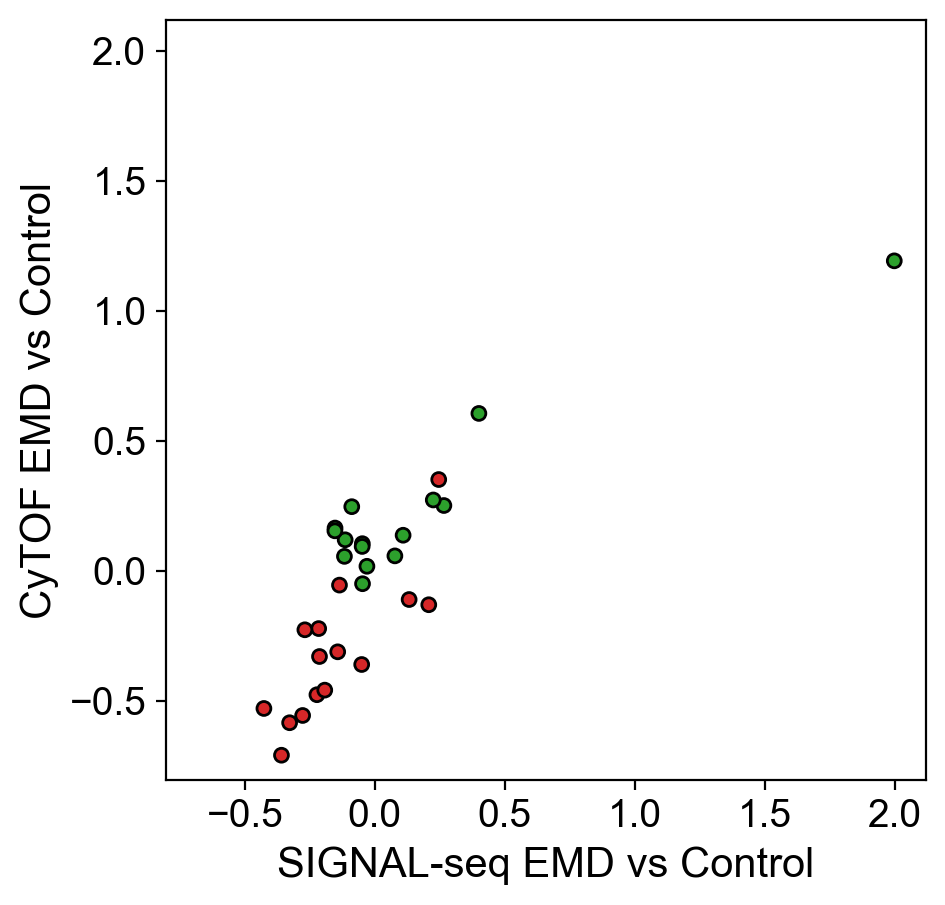

In [15]:
# plotting Colours
colors = {'Growth Factors':'tab:green', 'Inhibitors':'tab:red'}

fig, ax = plt.subplots()
ax.scatter(merged_df['ADT'], merged_df['CYTOF'], s=25, c=merged_df['condition'].map(colors), zorder=10, edgecolor='black')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Hide grid lines
ax.grid(False)

# Relable aspects
ax.set_aspect('equal')

# Adjust limits
ax.set_xlim(lims)
ax.set_ylim(lims)

# Axis labels
plt.xlabel('SIGNAL-seq EMD vs Control', fontsize=15)
plt.ylabel('CyTOF EMD vs Control', fontsize=15)

# Save figure
fig.savefig('figure_1/adt_vs_mc_emds_all.pdf', dpi=300)

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/2642404344.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(labels, (x[i], y[i]), fontsize=5, xytext=(3,3),


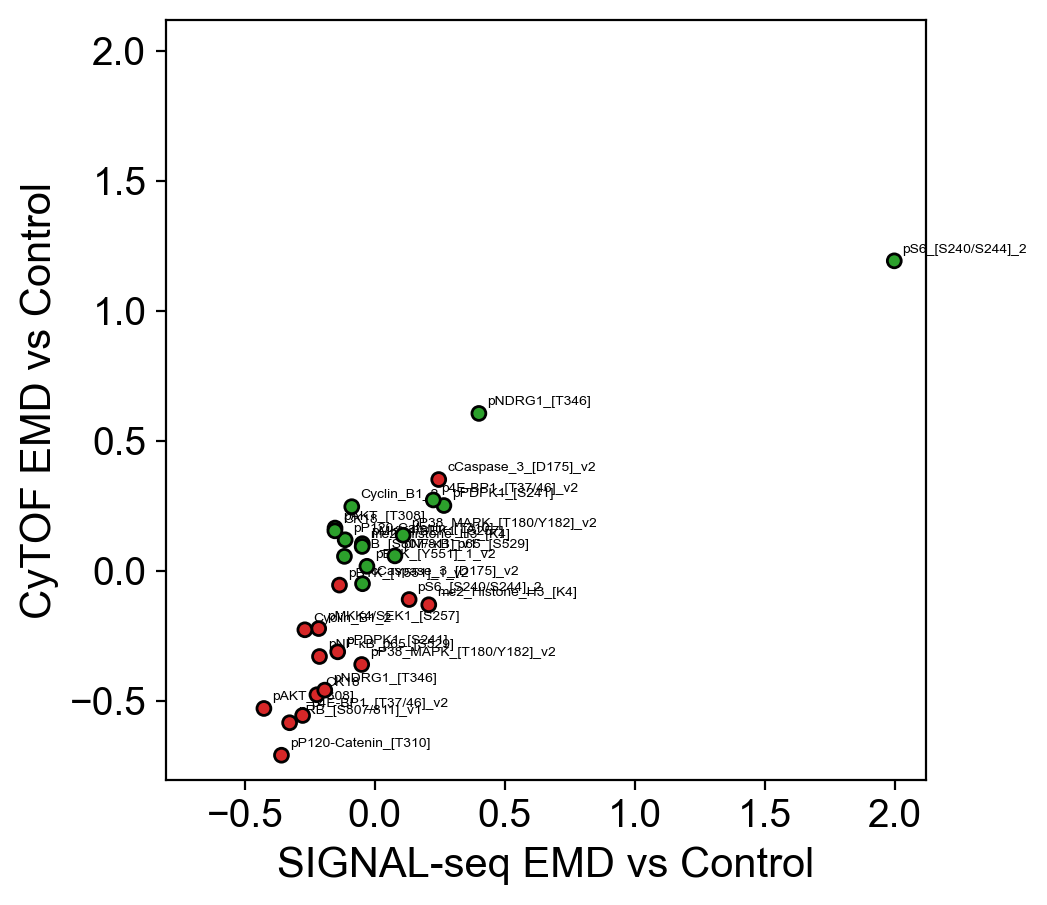

In [16]:
# Generate labels
labels = merged_df.index
x = merged_df['ADT']
y = merged_df['CYTOF']

# Colours
colors = {'Growth Factors':'tab:green', 'Inhibitors':'tab:red'}

fig, ax = plt.subplots()
ax.scatter(x, y, s=25, c=merged_df['condition'].map(colors), zorder=10, edgecolor='black')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

for i, labels in enumerate(labels):
    ax.annotate(labels, (x[i], y[i]), fontsize=5, xytext=(3,3),
                textcoords='offset points')

# Hide grid lines
ax.grid(False)

# Relable aspects
ax.set_aspect('equal')

# Adjust limits
ax.set_xlim(lims)
ax.set_ylim(lims)

# Axis labels
plt.xlabel('SIGNAL-seq EMD vs Control', fontsize=15)
plt.ylabel('CyTOF EMD vs Control', fontsize=15)

# Save figure
fig.savefig('figure_1/adt_vs_mc_emds_all_labelled.pdf', dpi=300)

In [17]:
# Run the EMD based on GF/STIM
adt_emd_stim = calculate_emd(emd_data=protein_data_clr_df_ptm, control_obs='sample_id', control_condition="GFs MEKi PI3Ki")

adt_emd_stim_hmap = adt_emd_stim.iloc[:, 0:2]
adt_emd_stim_hmap

,GFs MEKi PI3Ki,EGF IGF1
pP120-Catenin_[T310],0.0,0.386741
pRB_[S807/811]_v1,0.0,0.292287
cCaspase_3_[D175]_v2,0.0,-0.277828
pPDPK1_[S241],0.0,0.402131
pMKK4/SEK1_[S257],0.0,0.202468
pBTK_[Y551]_1_v2,0.0,0.135066
p4E-BP1_[T37/46]_v2,0.0,0.502657
pAKT_[T308],0.0,0.444535
pNF-κB_p65_[S529],0.0,0.230034
pP38_MAPK_[T180/Y182]_v2,0.0,0.153745


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/1762112183.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('coolwarm')


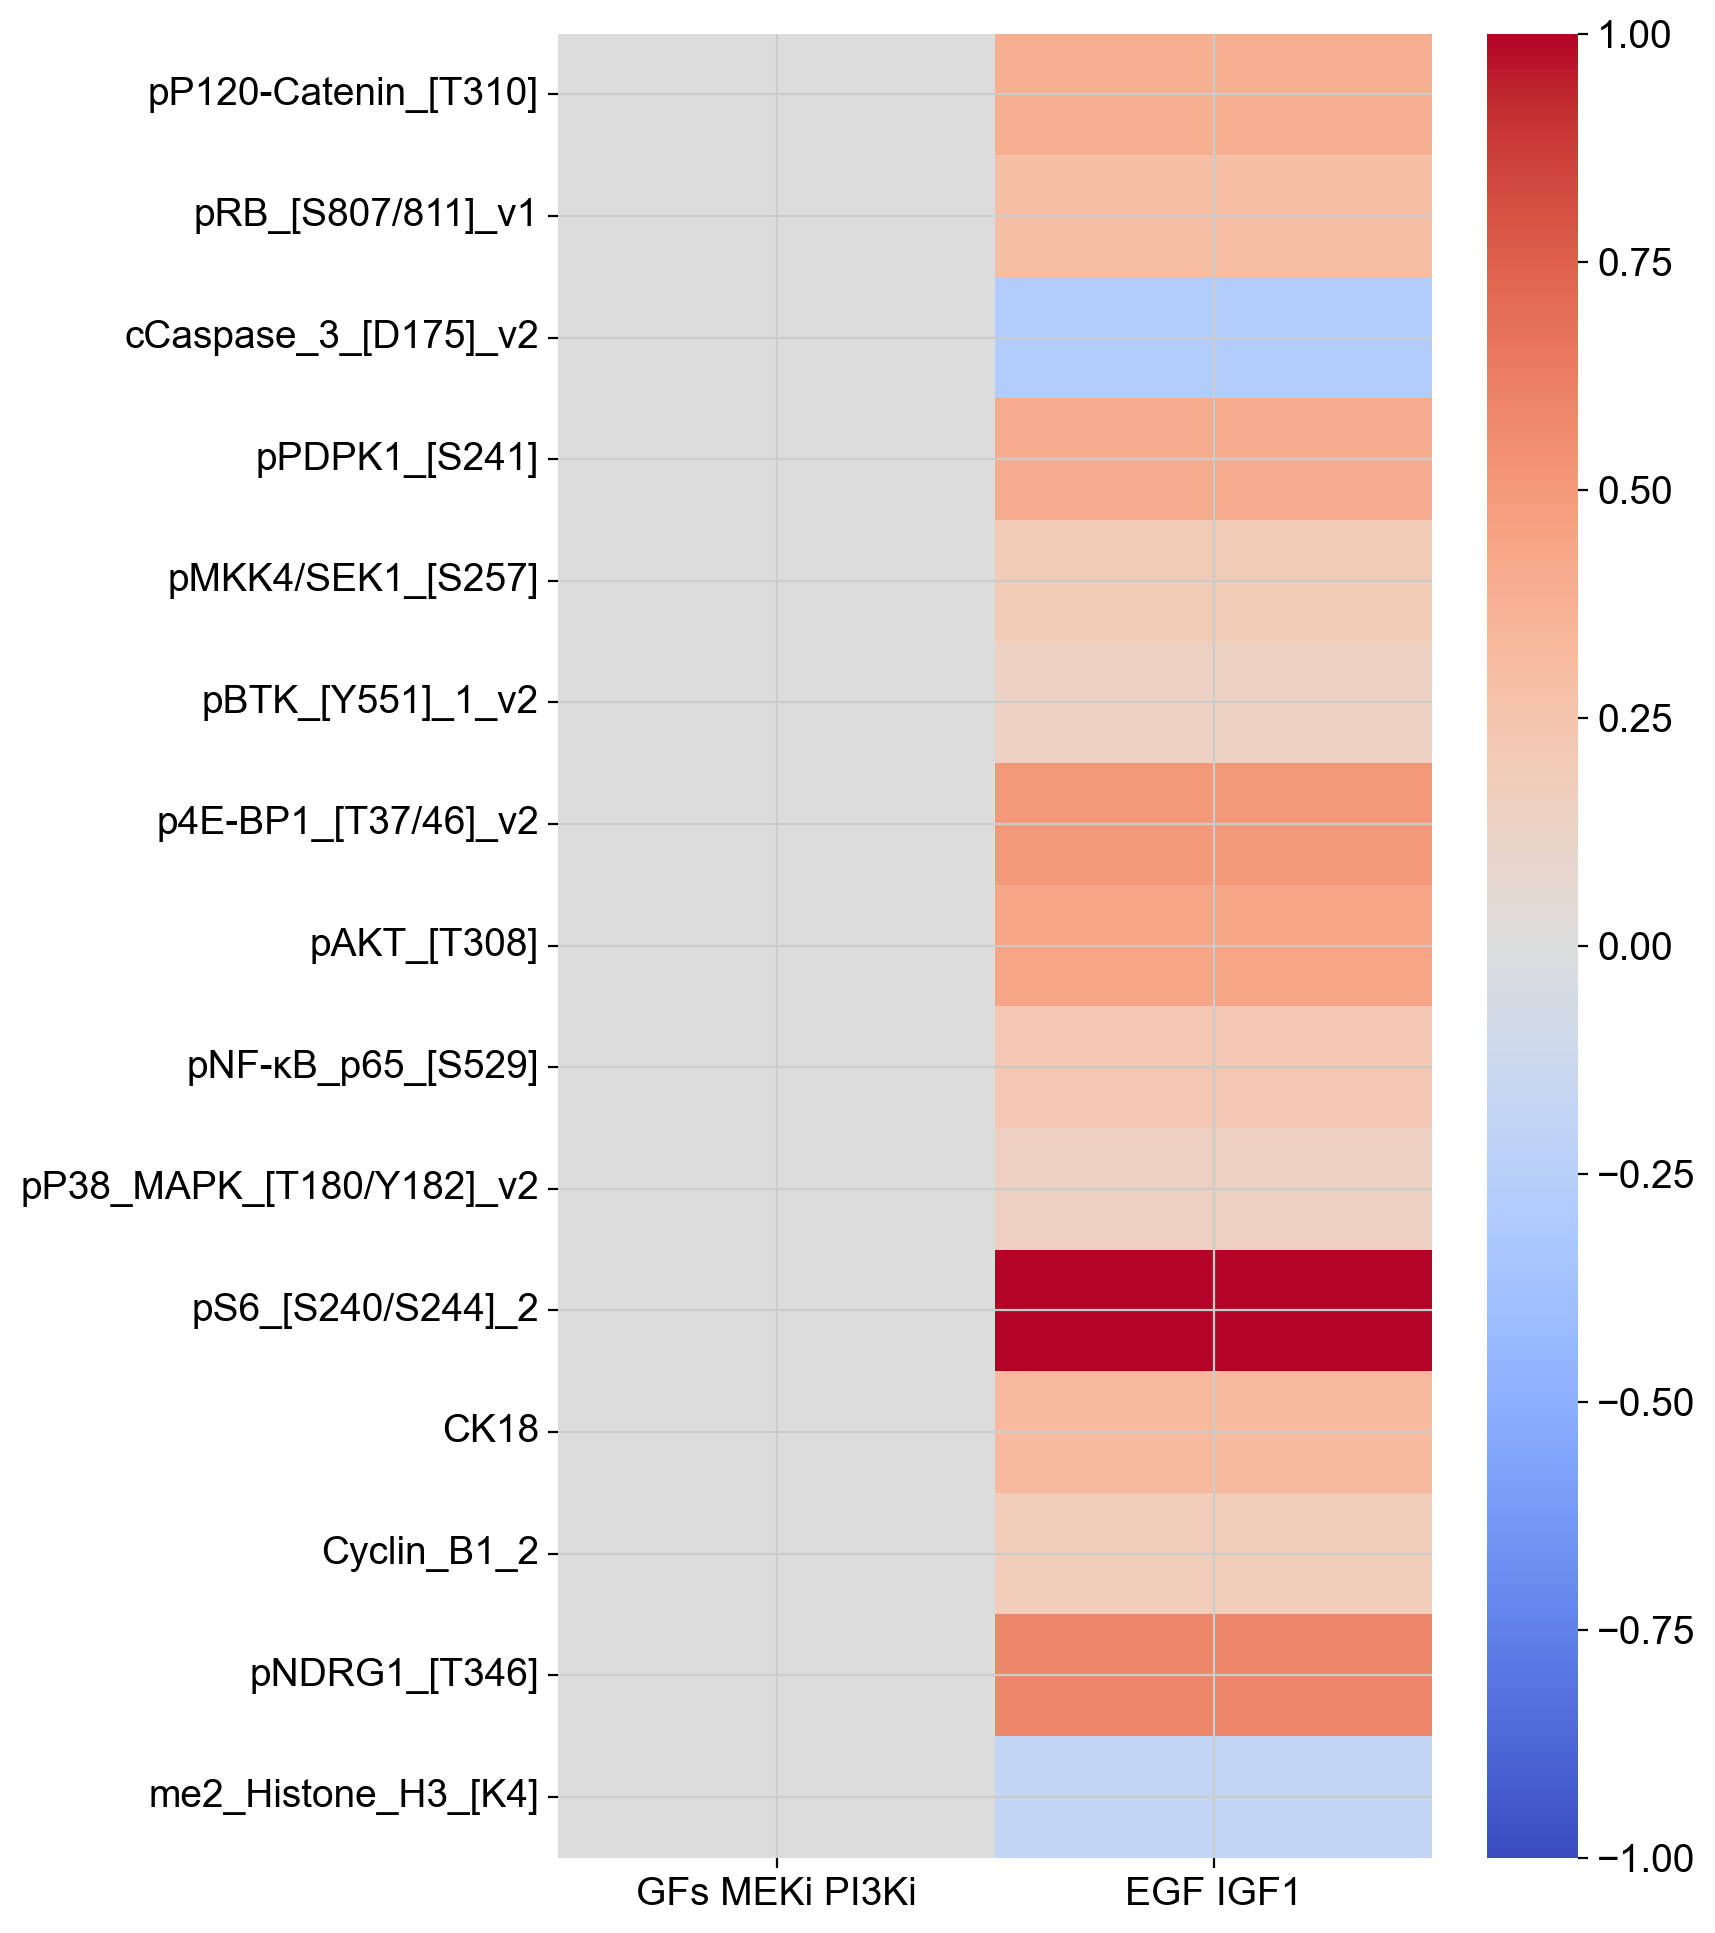

In [18]:
# Plote heatmap
fig, ax = plt.subplots(figsize=(7, 12))
colormap = mpl.cm.get_cmap('coolwarm')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -1, vmax = 1)
sns.heatmap(adt_emd_stim_hmap, cmap=colormap,norm=offset)
plt.savefig('figure_1/emd_adt_stim_vs_inhib.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [19]:
# Run the EMD based on GF/STIM
adt_emd_ihib = calculate_emd(emd_data=protein_data_clr_df_ptm, control_obs='sample_id', control_condition="EGF IGF1")

adt_emd_ihib = adt_emd_ihib.iloc[:, 0:2]
adt_emd_ihib

,GFs MEKi PI3Ki,EGF IGF1
pP120-Catenin_[T310],-0.386741,0.0
pRB_[S807/811]_v1,-0.292287,0.0
cCaspase_3_[D175]_v2,0.277828,0.0
pPDPK1_[S241],-0.402131,0.0
pMKK4/SEK1_[S257],-0.202468,0.0
pBTK_[Y551]_1_v2,-0.135066,0.0
p4E-BP1_[T37/46]_v2,-0.502657,0.0
pAKT_[T308],-0.444535,0.0
pNF-κB_p65_[S529],-0.230034,0.0
pP38_MAPK_[T180/Y182]_v2,-0.153745,0.0


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_42145/3455990614.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('coolwarm')


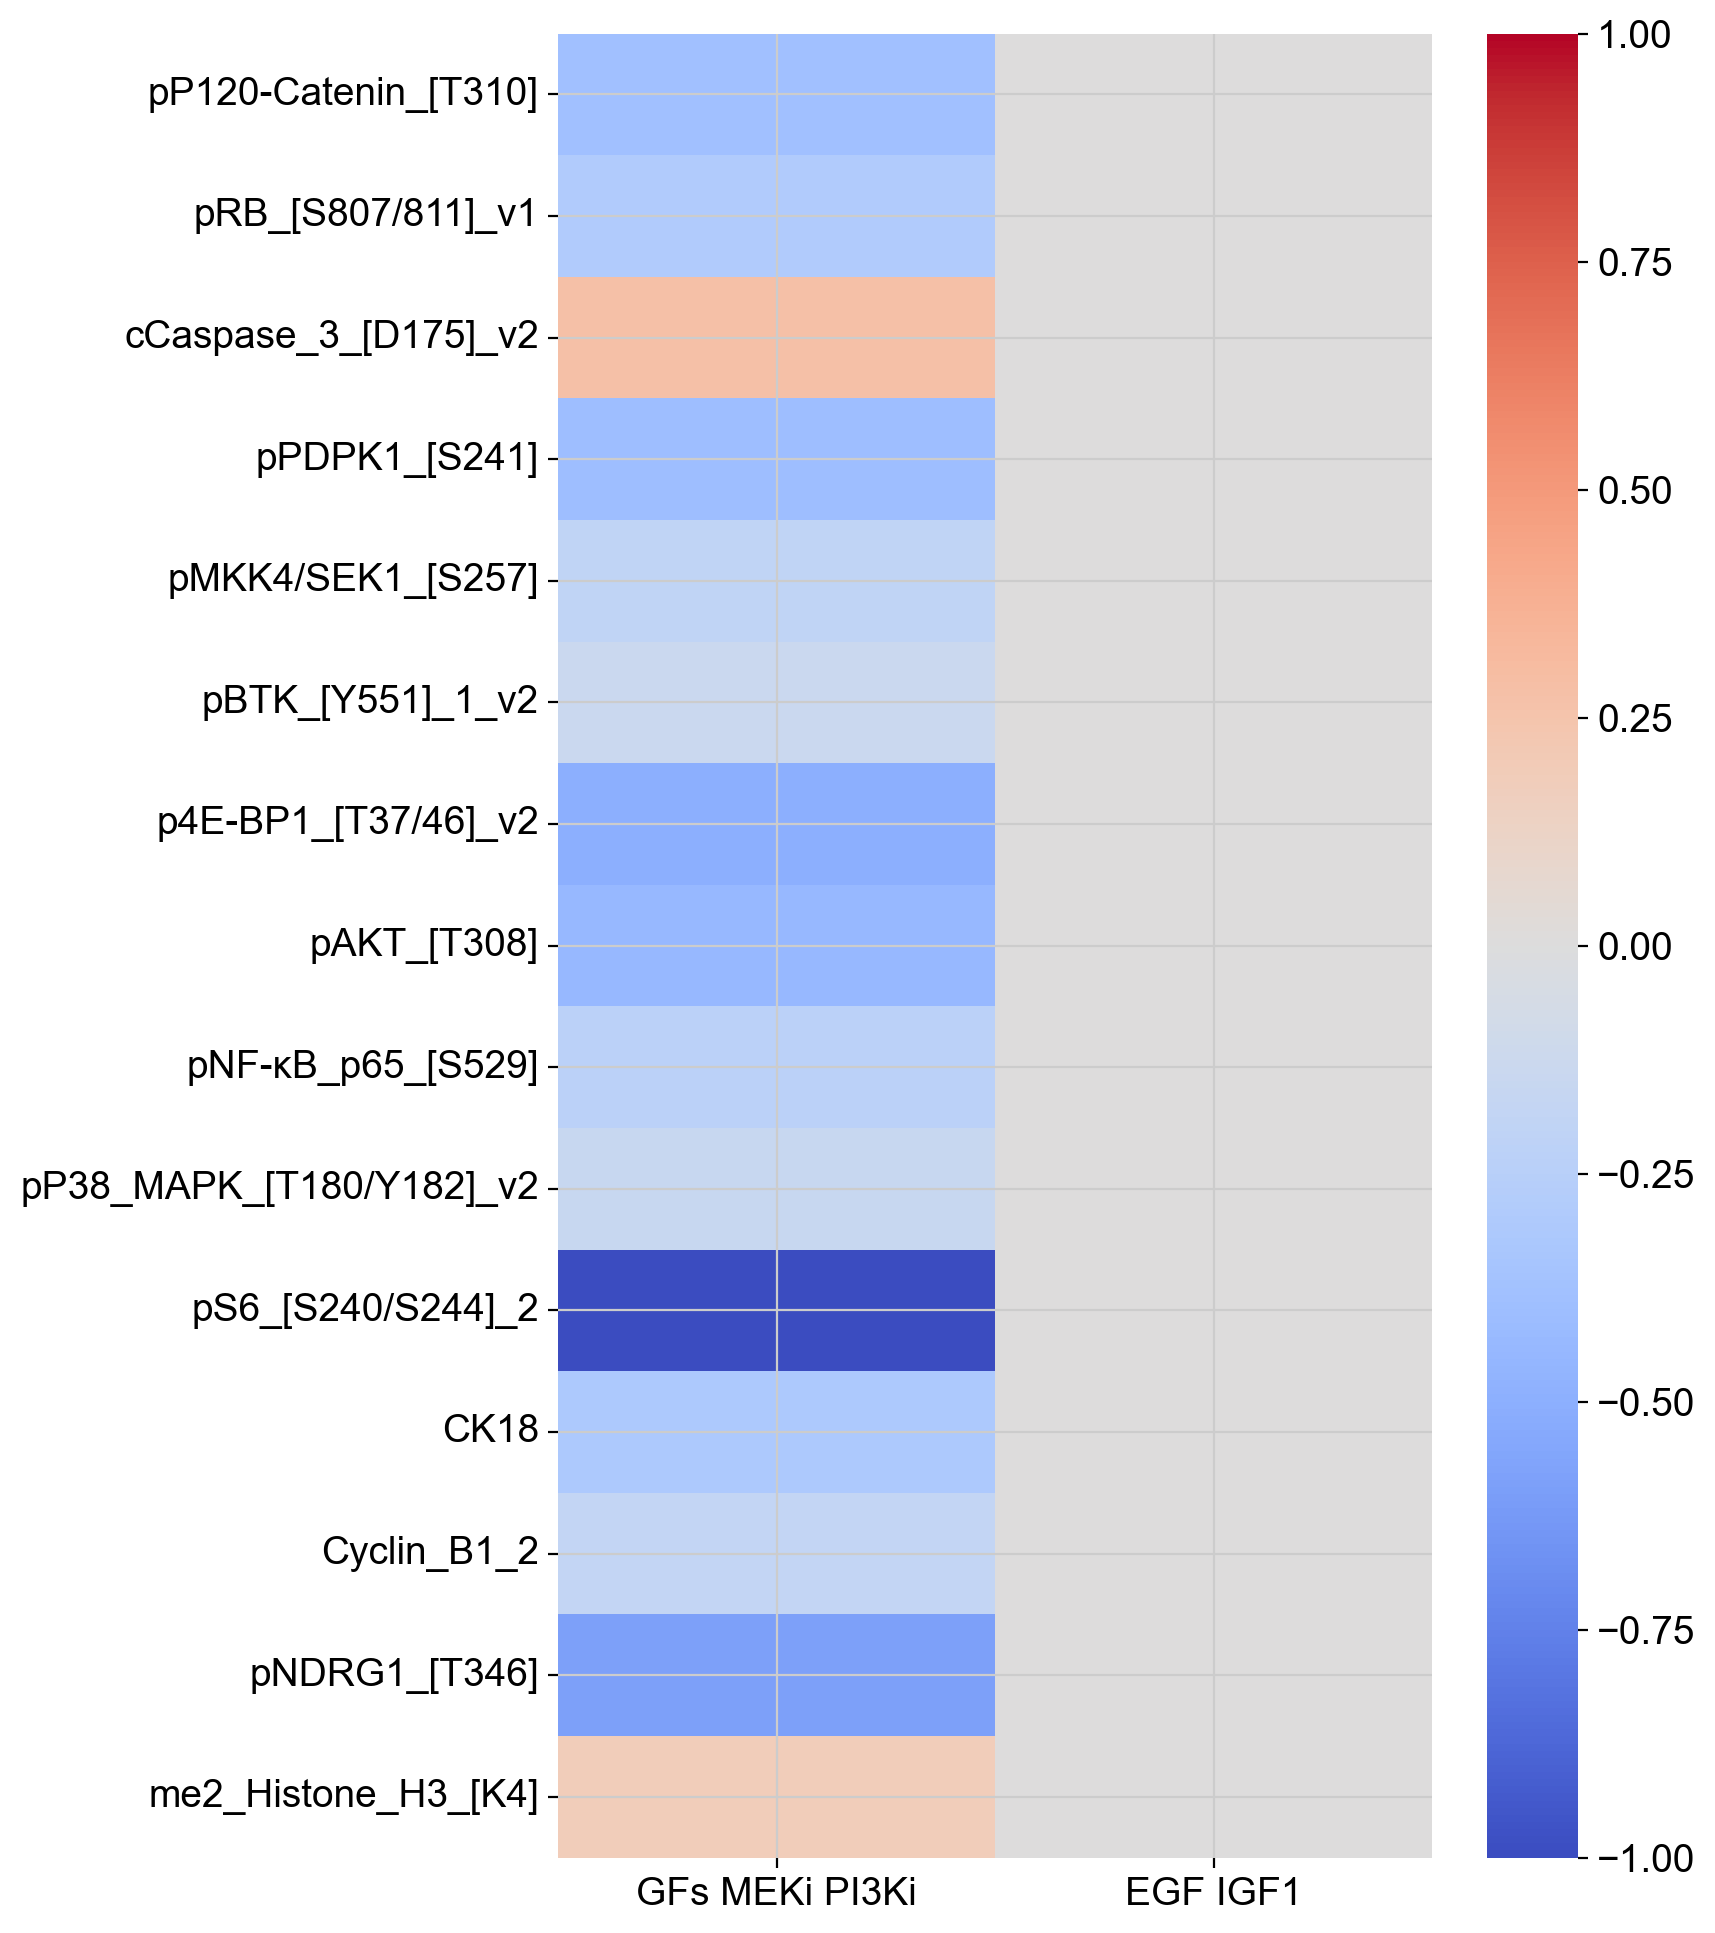

In [20]:
fig, ax = plt.subplots(figsize=(7, 12))
colormap = mpl.cm.get_cmap('coolwarm')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -1, vmax = 1)
sns.heatmap(adt_emd_ihib, cmap=colormap,norm=offset)
plt.savefig('figure_1/emd_adt_inhib_vs_stim.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()